In [1]:
import mysql.connector
import pandas as pd
import sys
sys.path.append('..')
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

# Connection to Mysql

#### Set the conection details

In [2]:
# Database connection details
host = 'localhost'
user = 'danicoco'
password = 'password'
database = 'legodb'

# Connect to the Database Legos

In [3]:
# Connect to the database
connection = connect_to_database(host, user, password, database)

# Queries to get the answers to our hypothesis

In [4]:
# Queries
queries = {
    "num_sets_per_theme": """
        SELECT themes.name AS Theme, COUNT(*) AS "Number of sets"
        FROM themes
        LEFT JOIN sets ON themes.id = sets.theme_id
        GROUP BY themes.name
        ORDER BY COUNT(*) DESC
        LIMIT 10;
    """,
    "top_sets_with_most_parts": """
        SELECT DISTINCT name, num_parts
        FROM sets
        ORDER BY num_parts DESC
        LIMIT 10;
    """,
    "top_sets_with_least_parts": """
        SELECT name, num_parts
        FROM sets
        WHERE num_parts >= 1
        ORDER BY num_parts ASC
        LIMIT 10;
    """,
    "themes_with_most_parts": """
        SELECT themes.name AS Theme, SUM(num_parts) AS "Total amount of parts for the theme"
        FROM themes
        LEFT JOIN sets ON themes.id = sets.theme_id
        GROUP BY themes.name
        ORDER BY SUM(num_parts) DESC
        LIMIT 10;
    """,
    "quantity_of_pieces_in_oldest_sets": """
        SELECT DISTINCT name, year, num_parts
        FROM sets
        WHERE year = (SELECT MIN(year) FROM sets)
        ORDER BY num_parts DESC
        LIMIT 10;
    """,
    "changes_in_quantity_of_pieces": """
        SELECT year, FLOOR(AVG(num_parts)) AS avg_num_parts
        FROM sets
        GROUP BY year
        ORDER BY year ASC;
    """
}

# Create dataframes and visualizations for each hypothesis

#### Hypothesis 1: Number of Sets per Theme This hypothesis examines which themes have the most sets.

In [5]:
df_num_sets_per_theme = query_to_dataframe(connection, queries['num_sets_per_theme'])
df_num_sets_per_theme

,Theme,Number of sets
0,Supplemental,904
1,Technic,666
2,City,572
3,Friends,519
4,Basic Set,505
5,Creator,493
6,Gear,477
7,Service Packs,435
8,Duplo,430
9,Construction,378


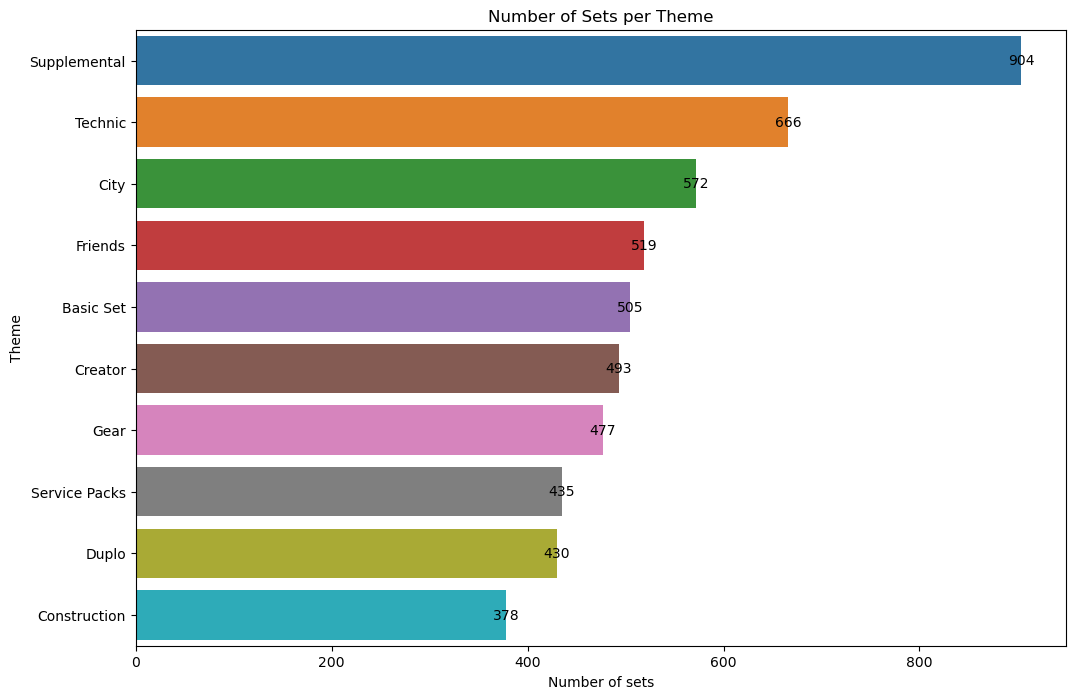

In [6]:
visualize_num_sets_per_theme(df_num_sets_per_theme)

##### Analysis: The analysis shows that Supplemental (904 sets) is the most extensive theme, indicating strong demand for additional parts. Technic (666 sets) and City (572 sets) follow, reflecting their popularity among consumers seeking complex builds and urban-themed scenarios. This data highlights key areas for focused marketing and product development.

#### Hypothesis 2: Top 10 Sets with the Most Parts Identifying the sets with the most parts highlights the most complex and potentially premium products. 

In [7]:
df_top_sets_with_most_parts = query_to_dataframe(connection, queries['top_sets_with_most_parts'])
df_top_sets_with_most_parts

,name,num_parts
0,Taj Mahal,5922
1,Star Wars / M&M Mosaic - Promo Set,5461
2,Window Exploration Bag,5200
3,Millennium Falcon - UCS,5195
4,Firehouse Headquarters,4640
5,Personalised Mosaic Portrait,4501
6,Tower Bridge,4295
7,Big Ben,4166
8,The Disney Castle,4060
9,Death Star,4023


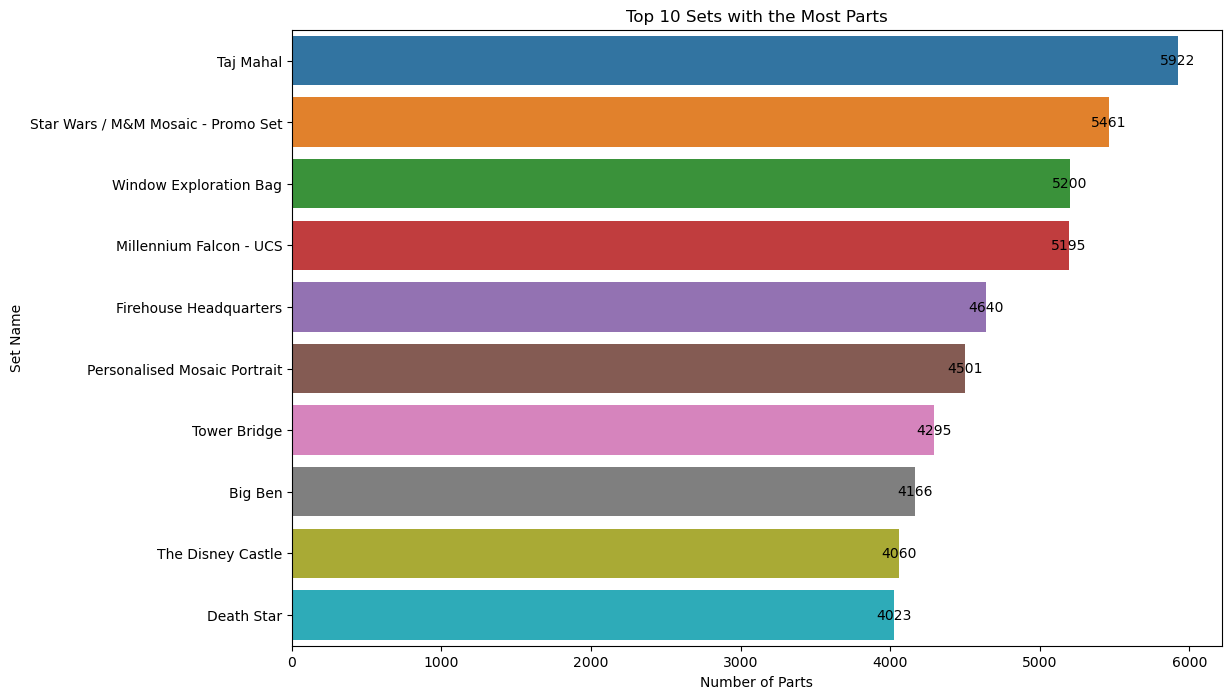

In [8]:
visualize_top_sets_with_most_parts(df_top_sets_with_most_parts)


##### Analysis:  The Taj Mahal leads with 5922 parts, followed by the Star Wars / M&M Mosaic (5461 parts) and Window Exploration Bag (5200 parts), showcasing the most complex and premium sets. These high-piece sets cater to advanced builders and are ideal for targeted marketing campaigns and strategic pricing, emphasizing their intricacy and value.

#### Hypothesis 3: Top 10 Sets with the Least Parts Conversely, knowing which sets have the fewest parts can indicate simpler, entry-level products suitable for younger children or those new to LEGO. 

In [9]:
df_top_sets_with_least_parts = query_to_dataframe(connection, queries['top_sets_with_least_parts'])
df_top_sets_with_least_parts

,name,num_parts
0,Train Connection Wire,1
1,Compass Sensor for Mindstorms NXT,1
2,Green Baseplate,1
3,4.5V Battery Case,1
4,Replacement 4.5V Motor,1
5,Intelligent NXT Brick (Black),1
6,4.5V Battery Case,1
7,Single Disk Pack,1
8,Sand Baseplate,1
9,2x2 Electrical Plate,1


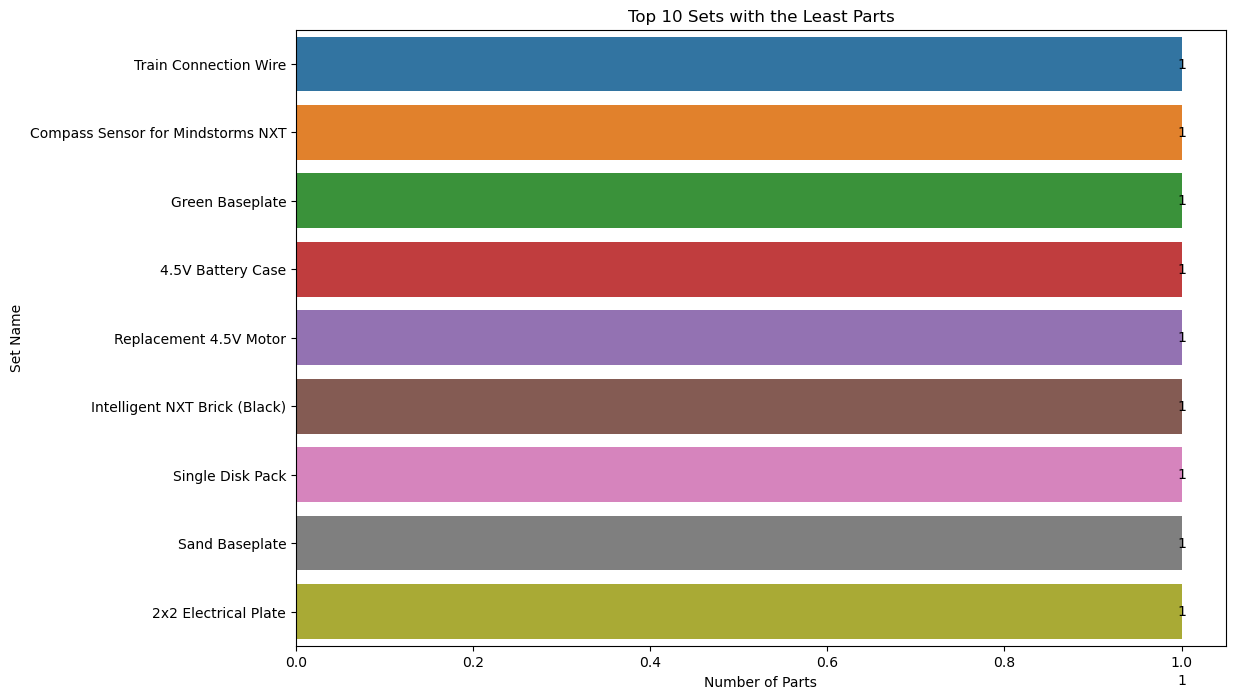

In [10]:
visualize_top_sets_with_least_parts(df_top_sets_with_least_parts)


##### Analysis: The top 10 sets with the least parts, each containing only one part, include items like the Train Connection Wire and Compass Sensor for Mindstorms NXT. These simpler, entry-level products are ideal for younger children or beginners, indicating a market for straightforward and easily accessible LEGO sets.

#### Hypothesis 4: Themes with the Most Parts This analysis reveals which themes contribute most to LEGO's total parts inventory.

In [11]:
df_themes_with_most_parts = query_to_dataframe(connection, queries['themes_with_most_parts'])
df_themes_with_most_parts

,Theme,Total amount of parts for the theme
0,Basic Set,199262
1,Star Wars Episode 4/5/6,166978
2,Construction,99943
3,Creator,90793
4,Technic,88527
5,Sculptures,78963
6,Traffic,77685
7,Ninjago,74767
8,Friends,69814
9,Star Wars,68111


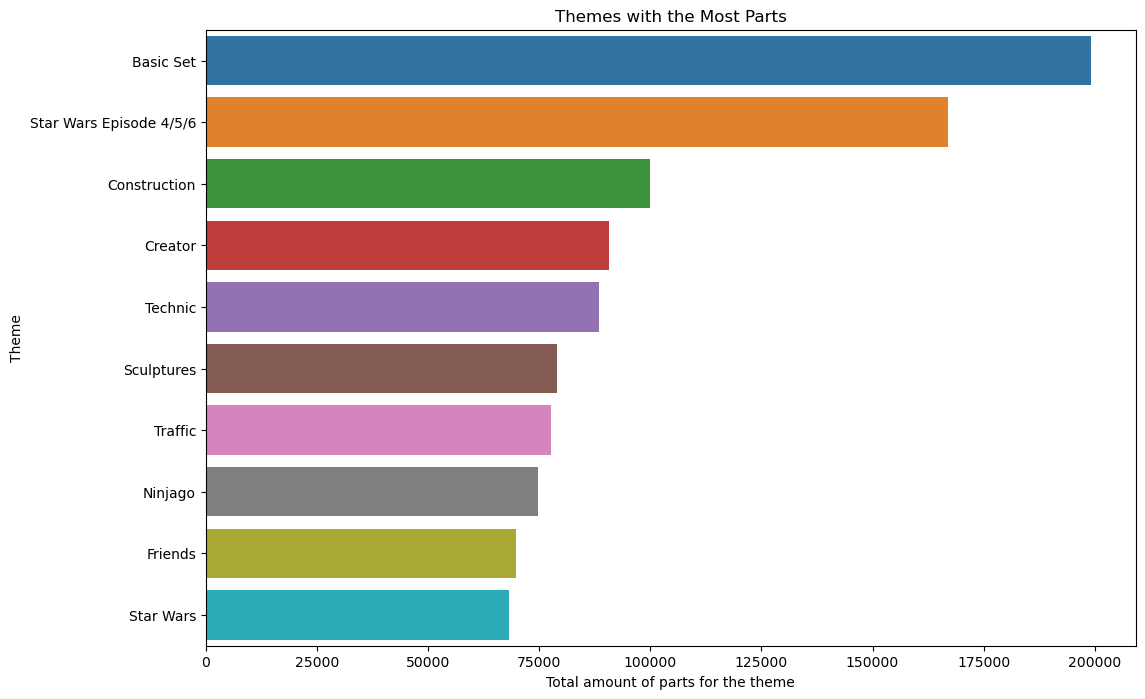

In [12]:
visualize_themes_with_most_parts(df_themes_with_most_parts)

##### Analysis: Basic Set leads with 199,262 parts, followed by Star Wars Episode 4/5/6 (166,978 parts) and Construction (99,943 parts). These themes dominate LEGO's total parts inventory, highlighting their complexity and significant resource allocation, crucial for managing product lines and investment strategies.

#### Hypothesis 5: Quantity of Pieces in the Oldest Sets Investigating the oldest sets provides historical context and showcases the evolution of LEGO set design.

In [13]:
df_quantity_of_pieces_in_oldest_sets = query_to_dataframe(connection, queries['quantity_of_pieces_in_oldest_sets'])
df_quantity_of_pieces_in_oldest_sets

,name,year,num_parts
0,Automatic Binding Bricks Small Brick Set (Lego...,1950,24
1,Individual 2 x 4 Bricks,1950,10
2,Individual 2 x 2 Bricks,1950,9
3,Individual 1 x 2 x 2 Window (without glass),1950,7
4,Individual 1 x 2 x 3 Window (without glass),1950,7
5,Individual 1 x 2 x 4 Door (without glass),1950,7
6,Individual 1 x 4 x 2 Window (without glass),1950,7


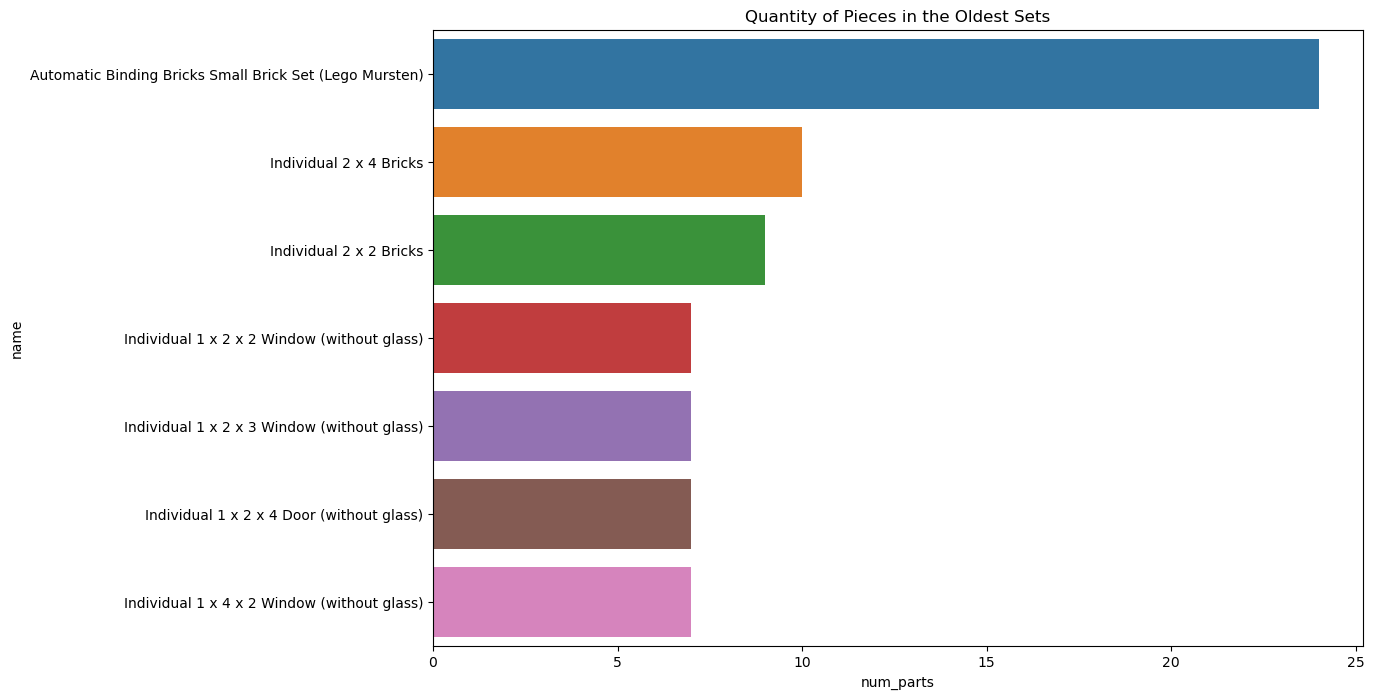

In [14]:
visualize_quantity_of_pieces_in_oldest_sets(df_quantity_of_pieces_in_oldest_sets)


##### Analysis: The oldest sets, like the Automatic Binding Bricks Small Brick Set from 1950 with 24 pieces, illustrate the humble beginnings of LEGO set design. These early sets, with few parts, provide valuable insights into the evolution of LEGO products and are ideal for nostalgic marketing and heritage storytelling.

#### Hypothesis 6: Changes in the Quantity of Pieces in LEGO Sets from 1950 until 2017.

In [15]:
df_changes_in_quantity_of_pieces = query_to_dataframe(connection, queries['changes_in_quantity_of_pieces'])
df_changes_in_quantity_of_pieces

,year,avg_num_parts
0,1950,10
1,1953,16
2,1954,12
3,1955,37
4,1956,19
...,...,...
61,2013,183
62,2014,172
63,2015,208
64,2016,264


/home/danicoco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/danicoco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


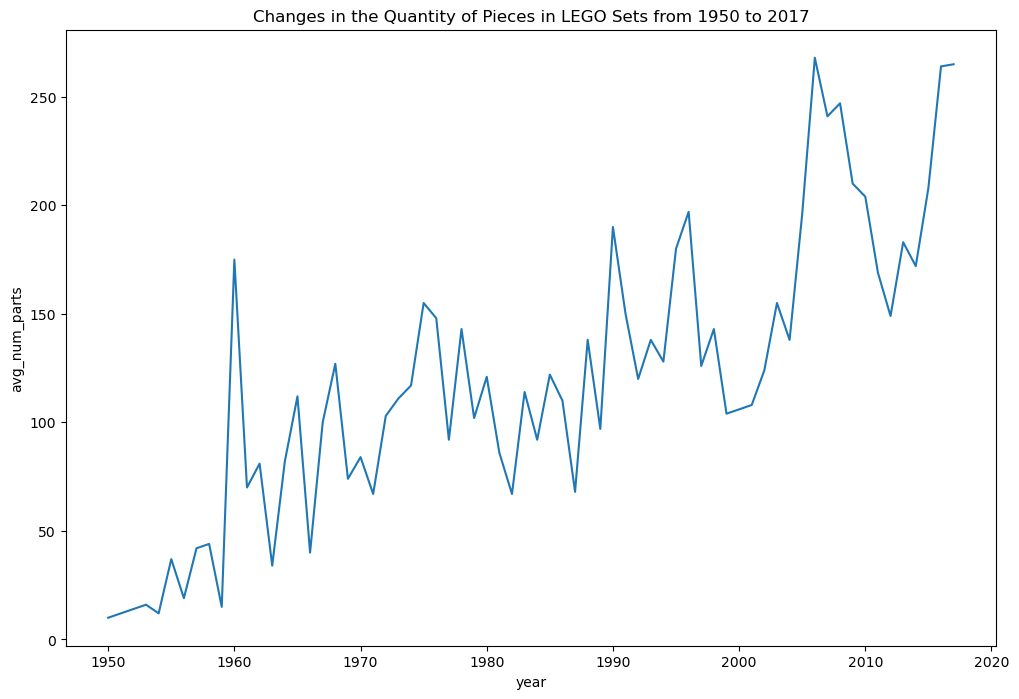

In [16]:
visualize_changes_in_quantity_of_pieces(df_changes_in_quantity_of_pieces)

##### Analysis: The average number of pieces in LEGO sets has significantly increased from 10 pieces in 1950 to 265 pieces in 2017, indicating a trend towards more complex and intricate designs. This trend reflects evolving consumer preferences and can guide future product development and strategic planning to meet the demand for more detailed sets.